## Import Packages

In [1]:
import zipfile as zf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm.notebook import tqdm
from PIL import Image

import future
from torch.utils.tensorboard import SummaryWriter

%load_ext autoreload
%autoreload 2

## Define the ENet model

We decided to model following residual blocks as separate class to model ENET encoder and decoder:
    - Initial block
    - RDDNeck - class for regular, downsampling and dilated bottlenecks
    - ASNeck - class for asymetric bottlenecks
    - UBNeck - class for upsampling bottlenecks

ENET architecture is autoencoder based model and is divided into 5 sub-blocks. Please refer [ENET paper](https://arxiv.org/pdf/1606.02147.pdf) for details of each sub-block. ENET building blocks code is taken from [here](https://github.com/iArunava/ENet-Real-Time-Semantic-Segmentation).

Fast scene understanding uses first 2 sub-blocks as encoder and remaining 3 as decoder. In this implemantation, there is 1 shared encoder and 3 separate decoder for 3 tasks(instance segementation, semantic segmentation, Depth estimation )

In [2]:
import os, sys
nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
from models.ENetDecoder import ENetDecoder
from models.ENetEncoder import ENetEncoder

class BranchedENet(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        # C - number of classes
        self.C = C
        
        self.enc = ENetEncoder(C)
        
        self.dec1 = ENetDecoder(C)
        self.dec2 = ENetDecoder(1)
        #self.dec3 = ENetDecoder(1)
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Output of Encoder
        x, i1, i2 = self.enc(x)
        # output of all 3 decoder in tuple
        #x = (self.dec1(x, i1, i2), self.dec2(x, i1, i2), self.dec3(x, i1, i2))
        x = (self.softmax(self.dec1(x, i1, i2)), self.dec2(x, i1, i2))
        return x

## Instantiate the ENet model

In [4]:
enet = BranchedENet(20)

In [5]:
# Checking if there is any gpu available and pass the model to gpu or cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
enet = enet.to(device)

## Define Dataloader

In [6]:
from data.cityscapes import Cityscapes as dataset

height = 512
width = 1024
dataset_dir = 'data/cityscape'
image_transform = transforms.Compose(
        [transforms.Resize((height,width)),transforms.ToTensor()])
train_set = dataset(dataset_dir,transform=image_transform)
test_set = dataset(dataset_dir,mode='test',transform=image_transform)

In [7]:
# get class weights
"""
train_loader = data.DataLoader(train_set,batch_size=1,num_workers=4)
trainiter = iter(train_loader)

all_labels_sum = 0
each_class = np.zeros(20)
for _ in tqdm(range(len(train_set))):
    _, labels, _, _ = trainiter.next()
    all_labels = labels.flatten()
    each_class += np.bincount(all_labels, minlength=20)
    all_labels_sum += len(all_labels)
    
propensity_score = each_class / all_labels_sum
class_weights = 1 / (np.log(1.02 + propensity_score))
"""
# manually define class weights from previous attempt
class_weights = [1.42227783, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979,
50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979,
50.49834979, 50.49834979]

In [8]:
# show the class weights
print(class_weights)

[1.42227783, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979, 50.49834979]


## 3 - Losses
(1) Semantic Segmentation Loss

(2) Instantance Segmentation Loss

(3) Depth Estimation Loss

In [9]:
def inverse_huber_loss(out, target):
    absdiff = torch.abs(out-target)
    C = 0.2*torch.max(absdiff)
    return torch.mean(torch.where(absdiff<C, absdiff, (absdiff*absdiff+C*C)/(2*C)))

## 7 - Define the Hyperparameters(todo)

In [10]:
lr = 5e-4
weight_decay = 5e-2
batch_size=2

# figure out enet_weighing issue
criterion_label = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
criterion_dpth = inverse_huber_loss
optimizer = torch.optim.Adam(enet.parameters(), 
                             lr=lr,
                             weight_decay=weight_decay)

## Name experiment to differentiate different runs for tensorboard
## eg. for hyperparameter tuning

experiment = 'experiment_lr-' + str(lr) + '_bc-' + str(batch_size) + '_wd-' + str(weight_decay) +' _softmax'

print_every = 2
eval_every = 2

## 8 - Training loop(todo)

In [11]:
train_losses = []
eval_losses = []

bc_train = 367 // batch_size # 367-mini_batch train
bc_eval = 101 // batch_size  # 101-mini_batch validation

epochs = 5000

train_writer = SummaryWriter(nb_dir+'/runs/' + experiment + '/train')
val_writer = SummaryWriter(nb_dir+'/runs/' + experiment + '/val')

In [12]:
start_e = 1

# # load saved model
pth = 'content/ckpt-enet-334-190689.095703125.pth'
checkpoint = torch.load(pth)
start_e = checkpoint['epochs']
enet.load_state_dict(checkpoint['state_dict'])

print(start_e)

334


data/cityscape/disparity_trainvaltest/disparity/train/bremen/bremen_000051_000019_disparity.png
data/cityscape/disparity_trainvaltest/disparity/train/strasbourg/strasbourg_000001_040761_disparity.png
data/cityscape/disparity_trainvaltest/disparity/train/strasbourg/strasbourg_000000_014235_disparity.png
data/cityscape/disparity_trainvaltest/disparity/train/hamburg/hamburg_000000_098616_disparity.png
data/cityscape/disparity_trainvaltest/disparity/train/hanover/hanover_000000_020655_disparity.png
data/cityscape/disparity_trainvaltest/disparity/train/strasbourg/strasbourg_000000_034040_disparity.png
data/cityscape/disparity_trainvaltest/disparity/train/jena/jena_000026_000019_disparity.png
data/cityscape/disparity_trainvaltest/disparity/train/bremen/bremen_000188_000019_disparity.png


data/cityscape/disparity_trainvaltest/disparity/train/strasbourg/strasbourg_000001_061285_disparity.png


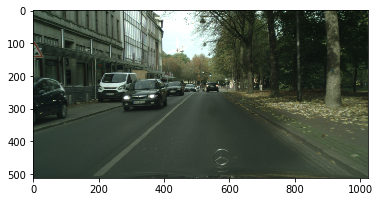

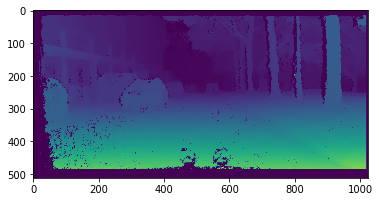

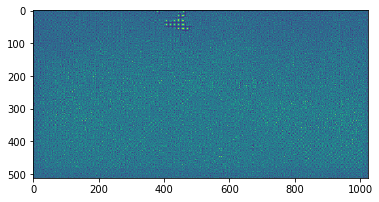

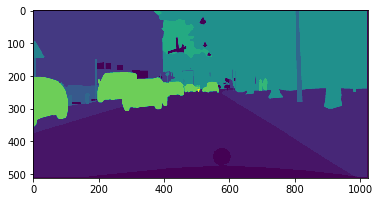

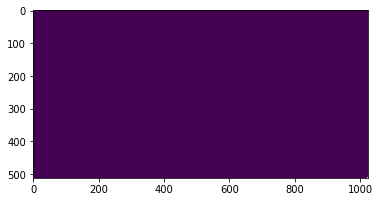

In [89]:
%matplotlib inline

# test with training data
enet.eval()
train_loader = data.DataLoader(train_set,batch_size=1,shuffle=True,num_workers=4)
trainiter = iter(train_loader)
img, label, inst, dpth = trainiter.next()
    
out = enet(img.to(device).float())
label_out, dpth_out = out[0], out[1]
#print(label_out)
dpth_out = 1*(dpth_out / torch.max(dpth_out))
dpth_out = dpth_out.detach().cpu()
label_out = torch.argmax(label_out.squeeze(), dim=0).detach().cpu().float()


dpth = Image.fromarray(dpth.numpy().squeeze())
#dpth_out = Image.fromarray(dpth_out.numpy().squeeze())
dpth_out = transforms.ToPILImage()(dpth_out.squeeze())

label = transforms.ToPILImage()(label.squeeze_(0))
#label_out = Image.fromarray(label_out.numpy().squeeze())
label_out = transforms.ToPILImage()(label_out.squeeze_(0))

img = transforms.ToPILImage()(img.squeeze_(0))
img.save('img.jpeg')
dpth_out.save('pred.jpeg')

plt.figure()
plt.imshow(img)

plt.figure()
#plt.subplot(1,2,1)
plt.imshow(dpth)
plt.figure()
#plt.subplot(1,2,2)
plt.imshow(dpth_out)

plt.figure()
#plt.subplot(1,2,1)
plt.imshow(label)
plt.figure()
#plt.subplot(1,2,2)
plt.imshow(label_out)

In [14]:
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,
        num_workers=4)

test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,
        num_workers=4)

trainiter = iter(train_loader)
testiter = iter(test_loader)

In [15]:
# Train loop

for e in range(start_e, epochs+1):
    
    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)
    
    enet.train()
    
    for _ in tqdm(range(bc_train)):
        # get new data/recycle if done
        try:
            img, label, inst, dpth = trainiter.next()
            
        except:
            train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=4)
            trainiter = iter(train_loader)
            img, label, inst, dpth = trainiter.next()
            
        # fix label as one hot pixel
        label = label.squeeze(1)
        label = 255*label
        
        # assign data to cpu/gpu
        img, label, inst, dpth = img.to(device), label.to(device), inst.to(device), dpth.to(device)

        optimizer.zero_grad()
        out = enet(img.float())

        # split output into two predictions
        label_out, dpth_out = out[0], out[1]

        # loss calculation for class segmentation
        loss = criterion_label(label_out, label.long()).float()

        # loss calculation for depth
        loss += criterion_dpth(dpth_out, dpth.float())
        loss.backward()
        
        # update weights
        optimizer.step()

        train_loss += loss.item()
        
    train_writer.add_scalar('Loss', train_loss/bc_train, e)
    
    if e % eval_every == 0:
        with torch.no_grad():
            enet.eval()
            
            eval_loss = 0

            # Validation loop
            for _ in tqdm(range(bc_eval)):
                # get new data/recycle if done
                try:
                    img, label, inst, dpth = testiter.next()

                except:
                    test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=4)
                    testiter = iter(test_loader)
                    img, label, inst, dpth = testiter.next()
                
                # fix label
                label = label.squeeze(1)
                label = 255*label
                    
                # assign data to cpu/gpu
                img, label, inst, dpth = img.to(device), label.to(device), inst.to(device), dpth.to(device)
        
                out = enet(img.float())
                
                # split output into two predictions
                label_out, dpth_out = out[0], out[1]

                # loss calculation for class segmentation
                eval_loss += criterion_label(label_out, label.long()).float().item()

                # loss calculation for depth
                eval_loss += criterion_dpth(dpth_out, dpth.float()).item()
                
            
            val_writer.add_scalar('Loss', eval_loss/bc_eval, e)
        
    if e % print_every == 0:
        checkpoint = {
            'epochs' : e,
            'state_dict' : enet.state_dict()
        }
        torch.save(checkpoint, nb_dir+'/content/ckpt-enet-{}-{}.pth'.format(e, train_loss))
        print ('Model saved!')
    train_writer.flush()
    val_writer.flush()

--------------- Epoch 286 ---------------



Model saved!
--------------- Epoch 287 ---------------



--------------- Epoch 288 ---------------



Model saved!
--------------- Epoch 289 ---------------



--------------- Epoch 290 ---------------



Model saved!
--------------- Epoch 291 ---------------



--------------- Epoch 292 ---------------



Model saved!
--------------- Epoch 293 ---------------



--------------- Epoch 294 ---------------



Model saved!
--------------- Epoch 295 ---------------



--------------- Epoch 296 ---------------



Model saved!
--------------- Epoch 297 ---------------



--------------- Epoch 298 ---------------



Model saved!
--------------- Epoch 299 ---------------



--------------- Epoch 300 ---------------



Model saved!
--------------- Epoch 301 ---------------



--------------- Epoch 302 ---------------



Model saved!
--------------- Epoch 303 ---------------



--------------- Epoch 304 ---------------



Model saved!
--------------- Epoch 305 ---------------



--------------- Epoch 306 ---------------



Model saved!
--------------- Epoch 307 ---------------



--------------- Epoch 308 ---------------



Model saved!
--------------- Epoch 309 ---------------



--------------- Epoch 310 ---------------



Model saved!
--------------- Epoch 311 ---------------



--------------- Epoch 312 ---------------



Model saved!
--------------- Epoch 313 ---------------



--------------- Epoch 314 ---------------



Model saved!
--------------- Epoch 315 ---------------



--------------- Epoch 316 ---------------



Model saved!
--------------- Epoch 317 ---------------



--------------- Epoch 318 ---------------



Model saved!
--------------- Epoch 319 ---------------



--------------- Epoch 320 ---------------



Model saved!
--------------- Epoch 321 ---------------



--------------- Epoch 322 ---------------



Model saved!
--------------- Epoch 323 ---------------



--------------- Epoch 324 ---------------



Model saved!
--------------- Epoch 325 ---------------



--------------- Epoch 326 ---------------



Model saved!
--------------- Epoch 327 ---------------



--------------- Epoch 328 ---------------



Model saved!
--------------- Epoch 329 ---------------



--------------- Epoch 330 ---------------



Model saved!
--------------- Epoch 331 ---------------



--------------- Epoch 332 ---------------



Model saved!
--------------- Epoch 333 ---------------



--------------- Epoch 334 ---------------



Model saved!
--------------- Epoch 335 ---------------


KeyboardInterrupt: 

In [ ]:
train_writer.close()
val_writer.close()